>>>> # <font color="orange"> Progetto Mars</font>

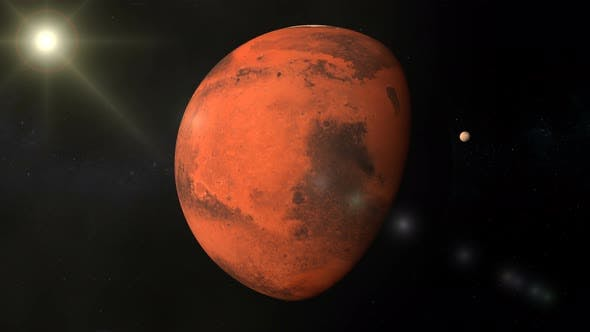

# Progetto
Mars è un progetto, dello studente di Informatica Rosario Pluchino dell'università di Catania, che consiste nella previsione della temperatura massima, su Marte. I dati vengono acquisiti da api.nasa.gov in formato json e tramite uno script python vengono prese le informazioni rilevanti per poi essere inserite in un file csv in modo da poter allenare successivamente questi dati.
{"sol_keys": [],"validity_checks": {"1099": {"AT": {"sol_hours_with_data": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"valid": false},"HWS": {"sol_hours_with_data": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"valid": false},"PRE"{"sol_hours_with_data[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"valid": false},"WD": {"sol_hours_with_data": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"valid": false}},"sol_hours_required": 18,"sols_checked": ["1099"]}}
Esempio di dati elaborati:
* 1895, 2018-02-27, 1977, 135, Month 5, -77, 727, 1, Sunny
* 1855, 2018-01-16, 1936, 115, Month 4, -79, 764, 1, Sunny
* 1850, 2018-01-12, 1932, 113, Month 4, -79, 768, 1, Sunny

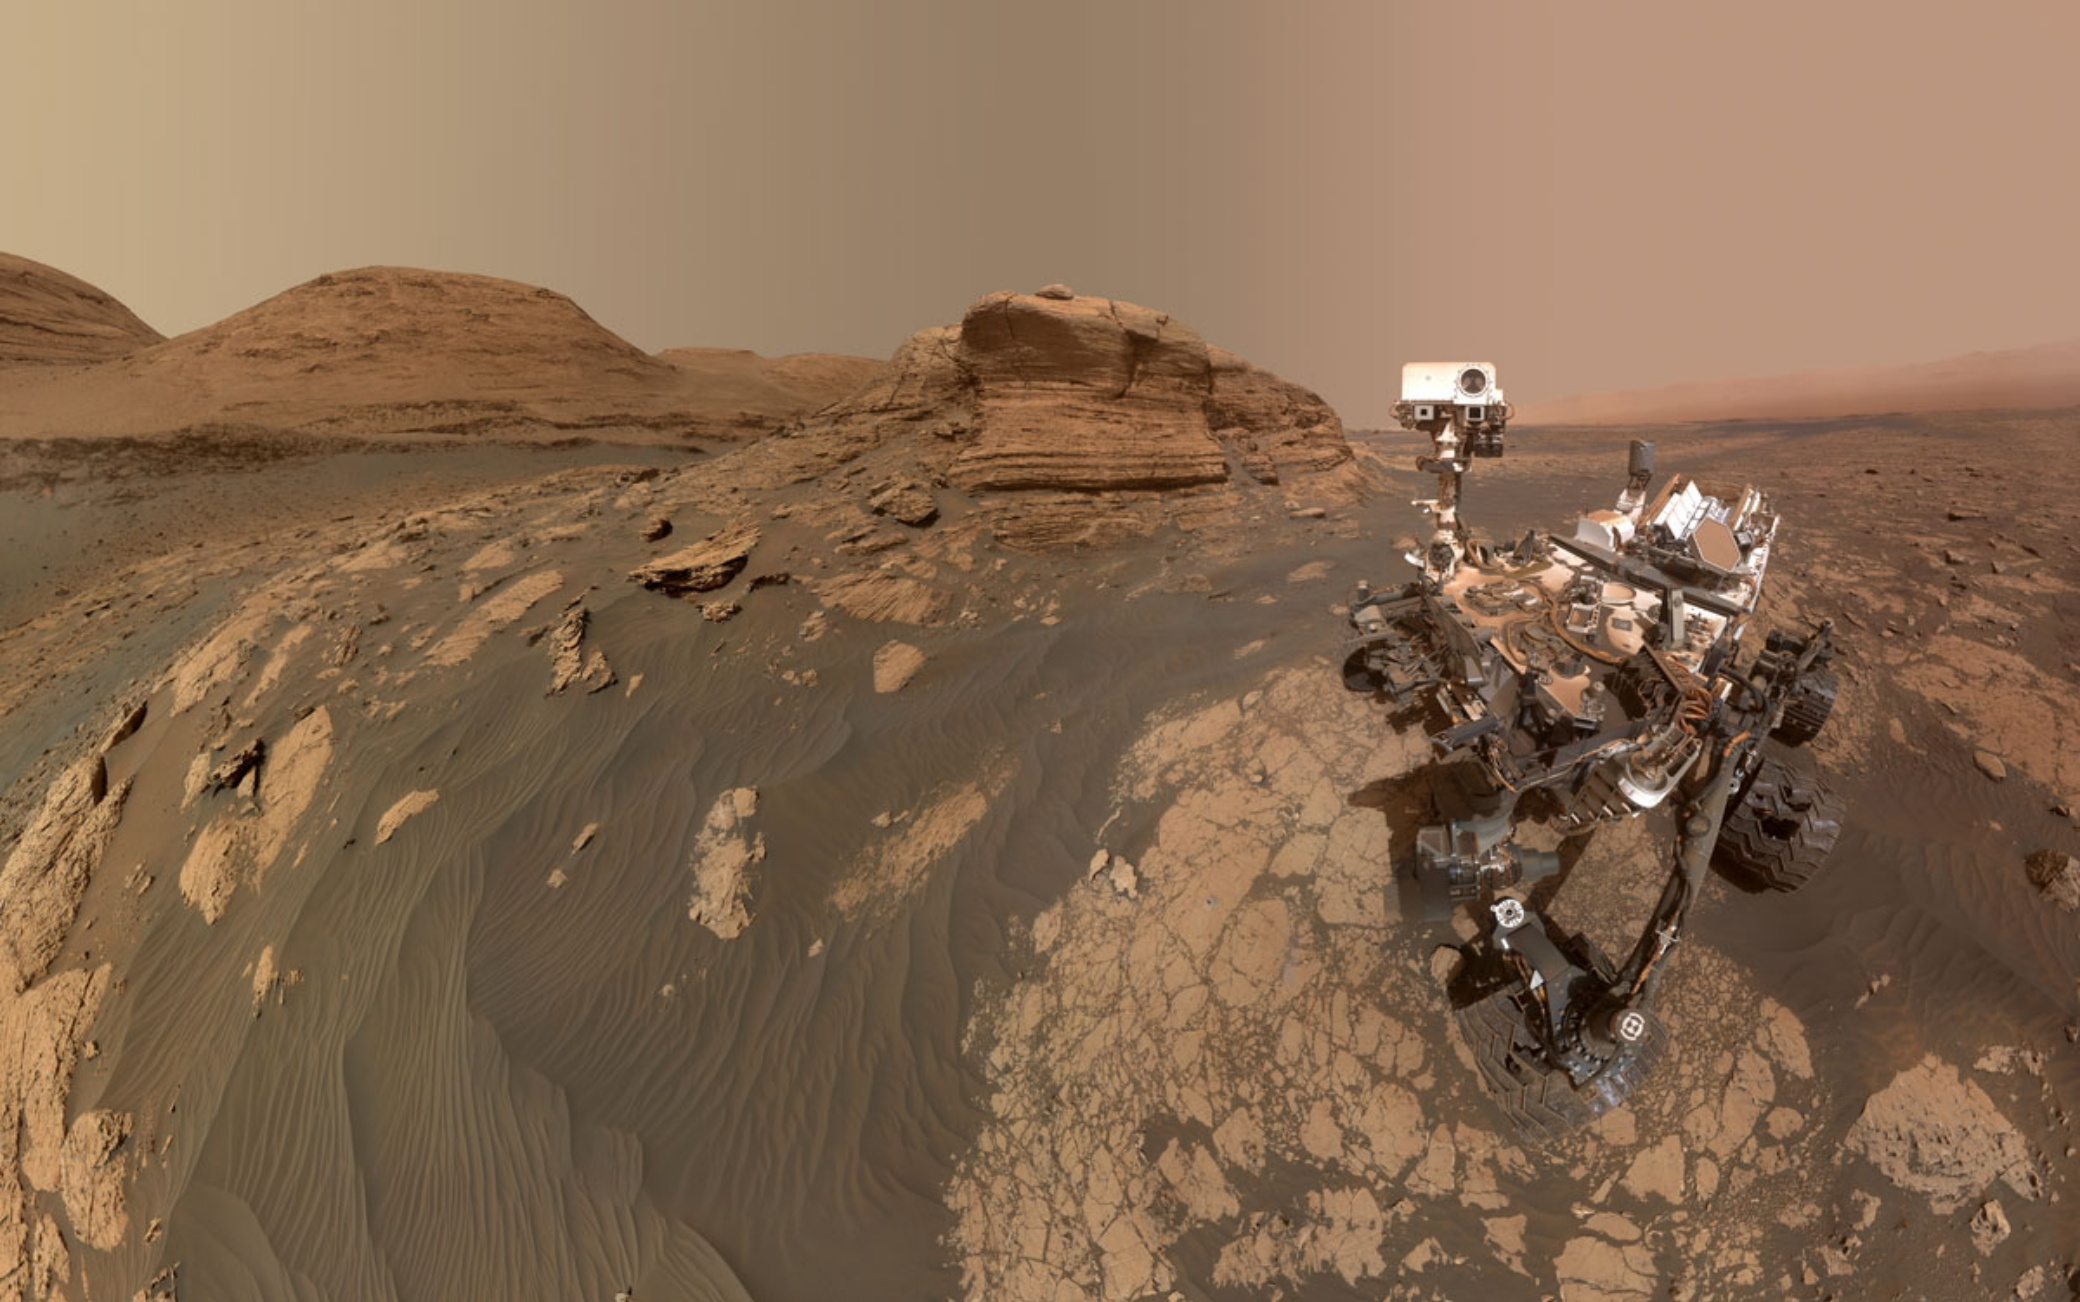

# Strumenti tecnologici <br>
> * *Logstash*
        data ingestion
> * *Kafka*
        streaming
> * *Spark Streaming*
        processing
> * *Spark Mlib*
        machine learning
> * *Elasticsearch*
        indexing
> * *Kibana*
        visualization

# Struttura del progetto

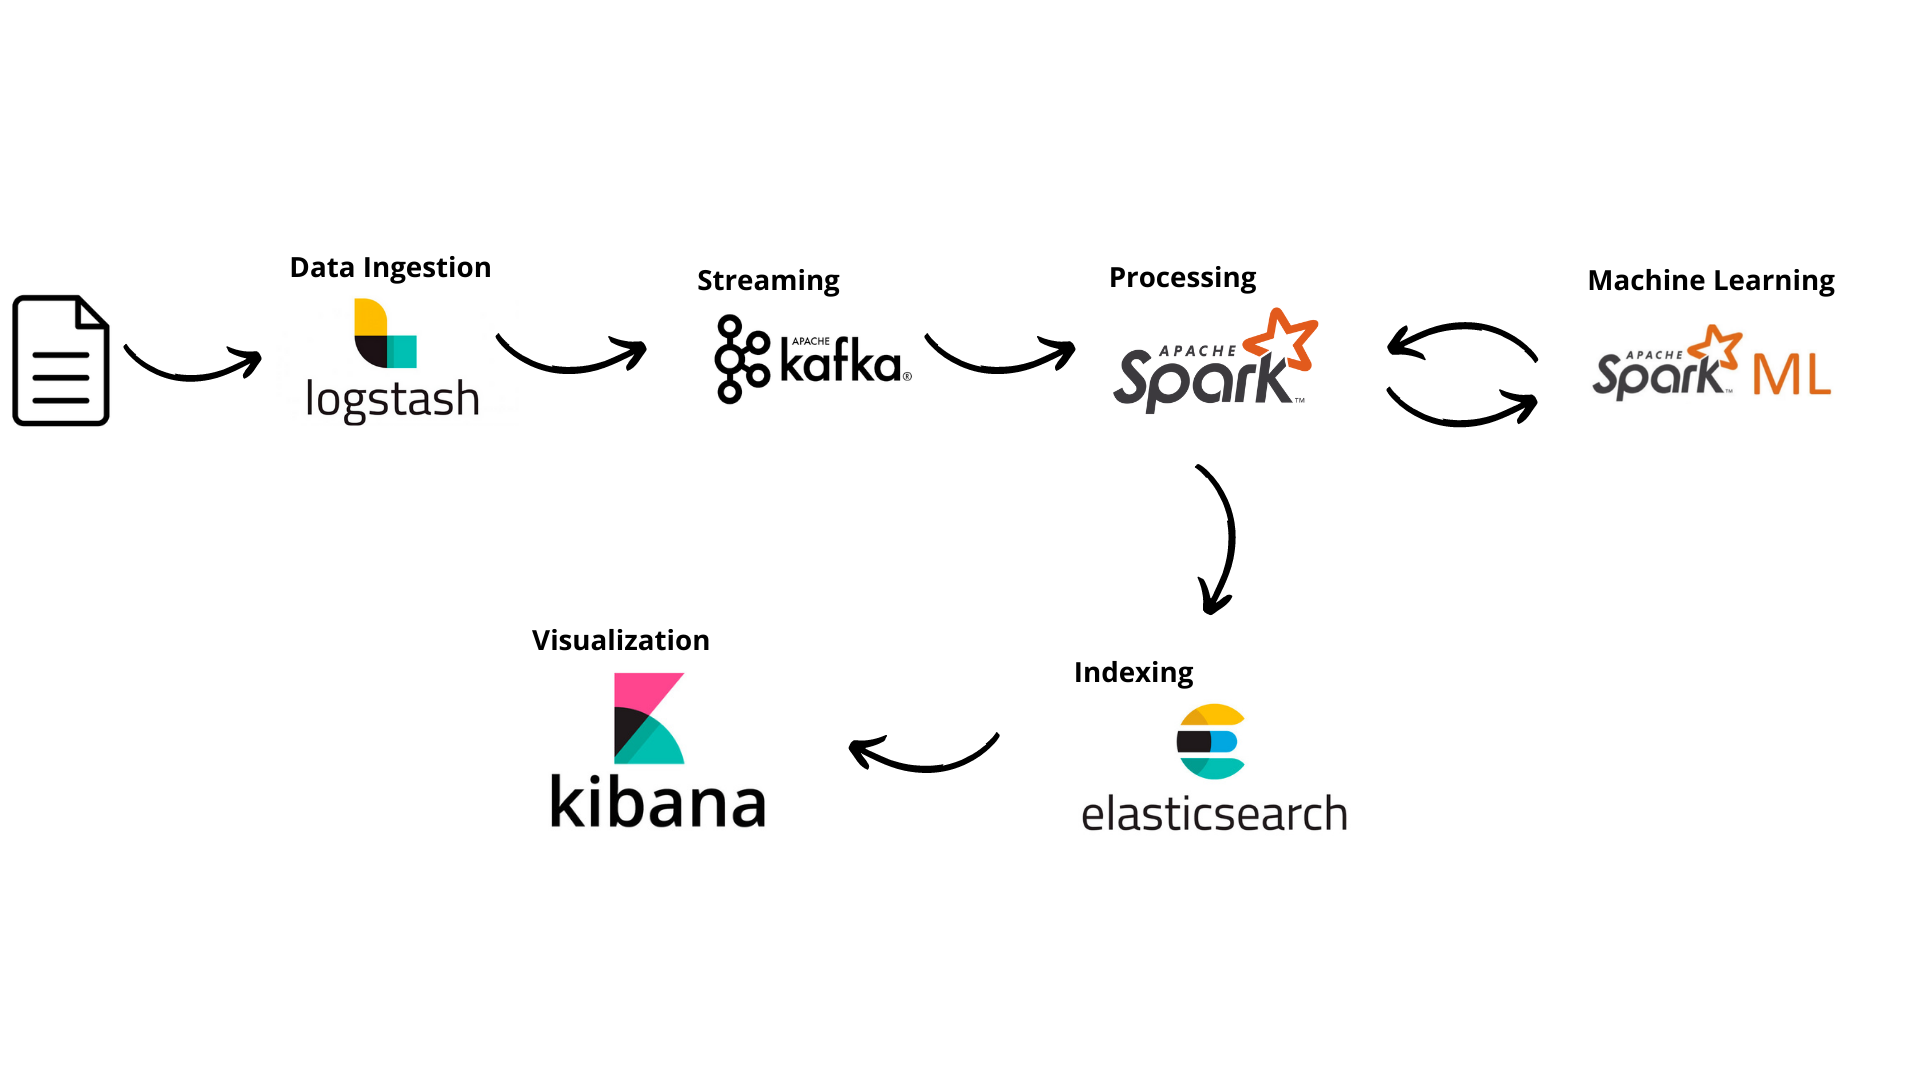

# Data Ingestion: Logstash

I dati vengono acquisiti da un file csv che contiene informazioni inviate dal rover Curiosity per poi essere raccolti da Logstash. Logstash è una pipeline di elaborazione dati che permette di raccogliere dati da varie fonti, elaborarli e inviarli ad altri software come kafka, elasticsearch e molti altri plug-in di output. La mia implementazione di Logstash consiste nel prendere gli eventi e inviarli a Kafka sul topic marsweather.

In [ ]:
input{
    file{
        path => "/leggo/input.csv"
        start_position => "beginning"
        stat_interval => 3
        id => "less"
    }
}


output{
    stdout{}
    kafka{
        codec => json
        topic_id => "marsweather"
        bootstrap_servers => "kafkaServer:9092"
    }
}

# Data Streaming: Kafka

Apache Kafka è un progetto che mira a creare una piattaforma a bassa latenza e ad alta velocità per la gestione dei feed(flussi) di dati in tempo reale. Viene eseguito come un insieme di app di servizi che girano in dei server, cioè cluster Kafka; quest'ultimi sono un insieme di computer connessi tra loro tramite reti di comunicazioni (nodi), i singoli nodi del cluster vengono chiamati broker che memorizzano gli stream di record in categorie chiamate topic. I produttori hanno il compito di scrivere i record su kafka, invece in consumatori hanno il compito di leggerli ed elaborarli. In questo progetto il ruolo del produttore è affidato a Logstash mentre il ruolo del consumatore è affidato a Spark.

# Data processing: Spark 
# Machine learning: Spark Mllib

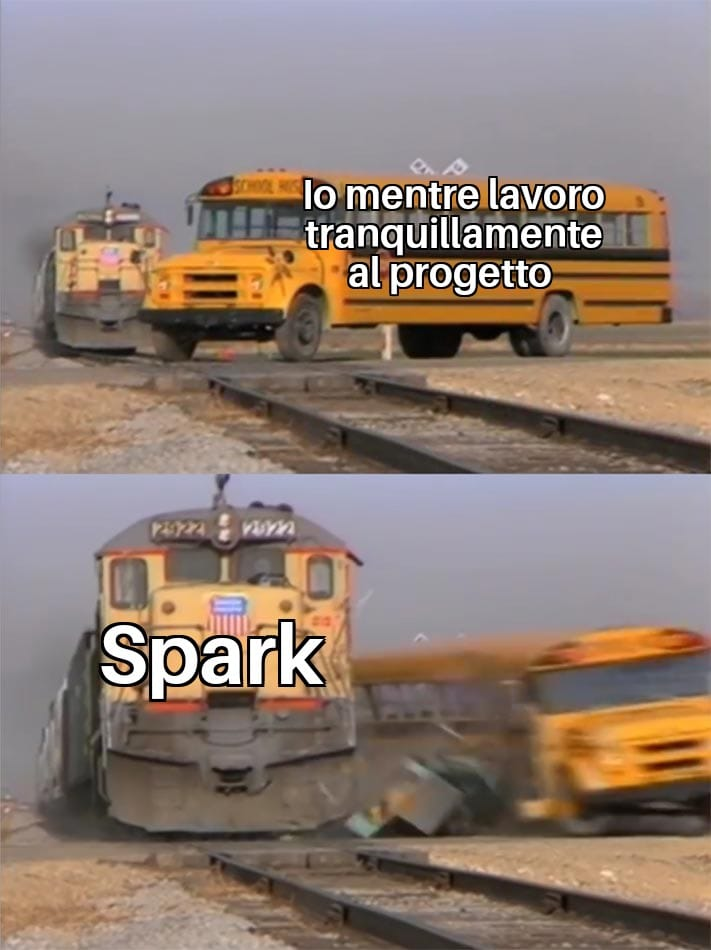

Apache Spark è un sistema di calcolo veloce e distribuito, consente di elaborare dati più velocemente rispetto ad altri software, come ad esempio Hadoop, esso ha memoria e ciò evita di far leggere i dati dal disco, è lazy e quindi non usa risorse dispendiose inutili ed è basato su Scala, Java e Python. In questo progetto i dati che arrivano in tempo reale da Kafka vengono trasformati in DataFrame e l'algoritmo utilizzato per la previsione della temperatura massima è la regressione lineare.

In [ ]:
#load the dataset
training_set = spark.read.csv(r'../dataset/file.csv',  inferSchema=True,  header=True) \
    .toDF("id",  "terrestrial_date",  "sol",  "ls",  "month",  "min_temp",  "max_temp",  "pressure",  "wind_speed",  "atmo_opacity")

#elimino le colonne dei dati che non mi servono
#drop the columns that are not required
training_set = training_set.drop(*['terrestrial_date','month','atmo_opacity'])
training_set.columns


#creating vectors from features
#creo vettori dalle features
#Apache MLlib takes input if vector form
#apache mllib accetta input solo se in forma vettore
vector_assembler = VectorAssembler(inputCols=['id','sol','ls','min_temp','pressure','wind_speed'],  outputCol='features',  handleInvalid="skip")

#final data consist of features and label which is max_temp
#i dati finali sono costituiti da features e label che è max_temp
final_data=vector_assembler.transform(training_set)

#divido i dati in train e test
#splitting data into train and test
train_data,  test_data=final_data.randomSplit([0.7, 0.3])

#creating an object of class LinearRegression
#object takes features and label as input arguments
#l'oggetto accetta features e label come argomenti in input
dfRegression = vector_assembler.transform(training_set) \
    .drop("id", "sol", "ls",  "min_temp",  "pressure", "wind_speed")
print("dfRegression")
dfRegression.show()

#alleno il modello
mars_lr=LinearRegression(featuresCol='features', labelCol='max_temp')

#pass train_data to train model
#addestro il modello con train_data
trained_mars_model=mars_lr.fit(train_data)

#evaluating model trained for Rsquared error
#valuto l'errore su modello allenato
mars_results=trained_mars_model.evaluate(train_data)

print("ERROR: ",  mars_results.r2)

#testing Model on unlabeled data
#testo il modello su dati senza etichetta quindi senza label

#create unlabeled data from test_data
#creo dati senza etichetta da test_data

#testing model on unlabeled data
#modello di test su dati non etichettati
unlabeled_data=test_data.select('features')
#unlabeled_data.show(5)
predictions=trained_mars_model.transform(unlabeled_data)

#below are the results of output from test data
#mostra i risultati dell'output dei dati di test
trained_mars_model.save("./linear/regressione2")
predictions.show()

# Data indexing: Elasticsearch

Elasticsearch è un motore di ricerca e di analisi distribuito per tutti i tipi di dati. Esso è il componente principale di Elastic Stack, un insieme di strumenti per l'acquisizione, l'arricchimento, l'archiviazione, l'analisi e la visualizzazione dei dati. I dati fluiscono in Elasticsearch da una varietà di fonti, l'acquisizione dei dati è il processo mediante il quale questi dati grezzi vengono analizzati, normalizzati e arricchiti prima di essere indicizzati. Un indice è una raccolta di documenti correlati tra loro, l'indice utilizzato nel progetto è marsweather.

# Data visualization: Kibana

Kibana è uno strumento di ricerca e visualizzazione dei dati indicizzati in Elasticsearch. Permette di creare grafici a barre, grafici a torta, tabelle, istogrammi e mappe. Una visualizzazione dashboard combina questi elementi visivi per poi essere condivisi tramite browser per fornire visualizzazioni analitiche in tempo reale.

Un'esempio di Dashboard:

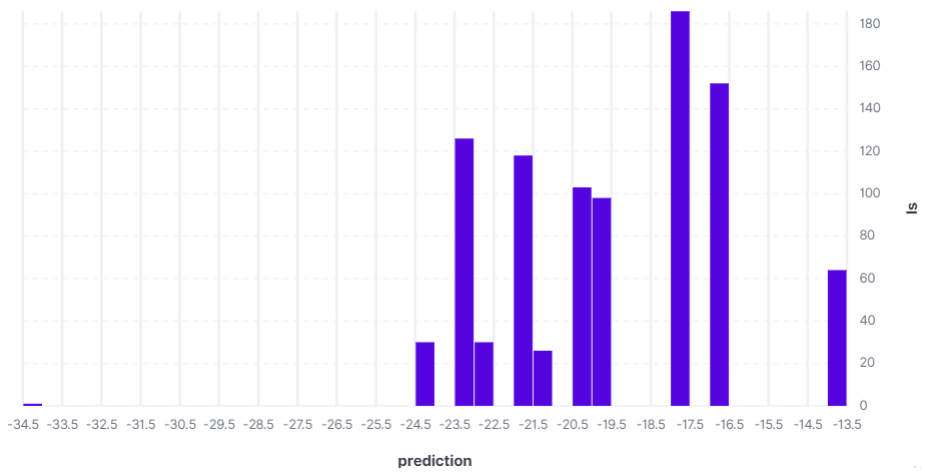

In questa Dashboard è presente un istogramma con due diversi tipi di dati: nell'asse orizzontale è presente la prediction cioè la stima della temperatura massima, invece nell'asse verticale è presente ls(longitudine solare). Essa, grazie a degli intervalli numerici, ci aiuta a capire a quale stagione ci si riferisce poichè ls=0 indica l'equinozio d'Autunno, ls=90 indica il solsitzio d'Inverno, ls=180 indica l'equinozio di Primavera mentre ls=270 indica il solsitizio d'Estate; è facile intuire quindi che più è alto ls più è alta la temperatura massima (a meno di qualche eccezione meteorologica).

Altri esempi di Dashboard:

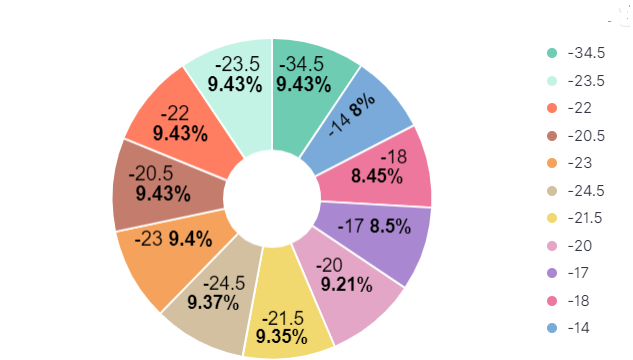

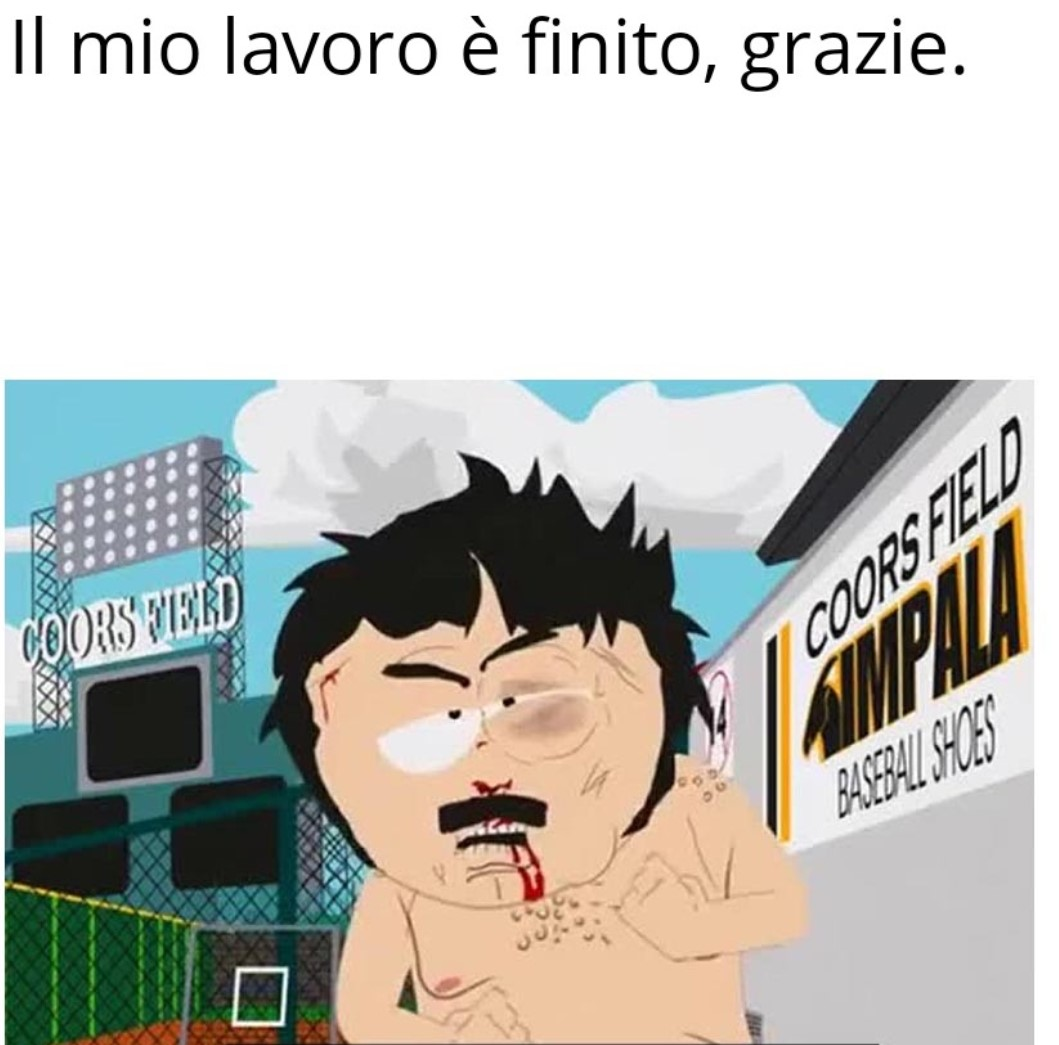